<a href="https://colab.research.google.com/github/flaviovdf/musica/blob/main/notebooks/lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Descomente e rode para usar no colab
# ! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-62wdk6fw
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-62wdk6fw


# Decomposição de Matrizes Musicais

**Objetivos**
1. Revisar Decomposição de Matrizes
1. Revisar SVD
1. Aprender um pouco sobre NMF

**Resultado Esperado**
1. Saber fazer uso do SKLearn para separar instrumentos

In [5]:
from μsica import μsf
from μsica import μsp

from numba import jit

import jax

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [6]:
μsp.init_matplotlib()
plt.ion()

## Introdução

Como vimos em sala de aula, a tarefa de separação de fontes (*source separation*) serve para extrair diferentes padrões de aúdio que se repetem em uma música. Aqui, um padrão pode ser visto como informação redundante na matriz do espectrograma de tempo curto. Como tal padrão se repete, a separação de fontes visa capturar os diferentes instrumentos tocados na música.

## Decomposição em Valores Singulares

Em álgebra linear, a decomposição em valores singulares ou singular value decomposition (SVD) é a fatoração de uma matriz real ou complexa, com diversas aplicações importantes em processamento de sinais e estatística.

Formalmente, a decomposição em valores singulares de uma matriz m×n real ou complexa X é uma fatoração ou fatorização na forma: 

$$ X = U \Sigma V^{*} $$ 

Aqui, $U$ é a matriz de vetores singulares à direita. $\Sigma$ é uma matriz diagonal com os valores singulares. Por fim, $V^{*}$ é a transposta conjugada dos valores singulares à direita. *Possivelmente você deve estar pensando: "massa, um monte de termo que sei muito pouco sobre"*. Se este é o seu caso, não se preocupe! Vamos tentar focar em uma ideia mais simples de SVD.

Para tal, uma outra forma de escrever tal equação é:

$$ X = U_s V^{t} $$ 

onde, $U_s = U \Sigma$, ou seja, o produto da primeira parte da equação acima. Aqui, $V^{t}$ é simplesmente transposta de $V$. Não vamos nos preocupar com transpostas conjugadas pois vamos trabalhar com números reais.

Em sua forma correta, $ X = U \Sigma V^{*} $, SVD consegue decompor qualquer matriz, $X$, real ou complexa. A decomposição também vai ser complexa, isto é, $U$, $\Sigma$ e $V$ podem conter números complexos. É importante ressaltar este fato para deixar claro que SVD consegue trabalhar no espectrograma complexo caso seja necessário. Fazemos uso da versão modificada aqui, pois conseguimos visualizar o espectro usando a norma dos números complexos, ou seja, um valor real.

Anyes de começar vamos olhar para o espectrograma de um pequeno trecho musical.

In [ ]:
μsf.download('http://dcc.ufmg.br/~flaviovdf/mir/examples/drum.wav', 'drum.wav',
             False)

drum.wav: 0.00B [00:00, ?B/s]

In [ ]:
wav, sr = librosa.load('drum.wav')
ipd.Audio(wav. fs=sr)

In [ ]:
### Qual a ideia de SVD?

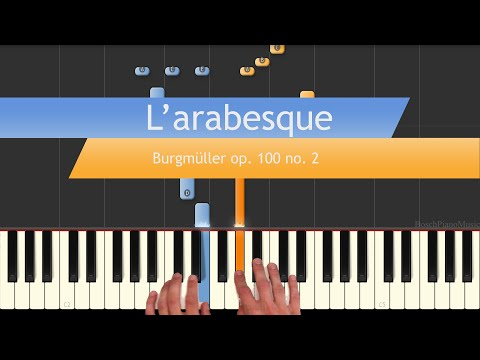

In [ ]:
ipd.YouTubeVideo('ZTJ0AYKNdgI')

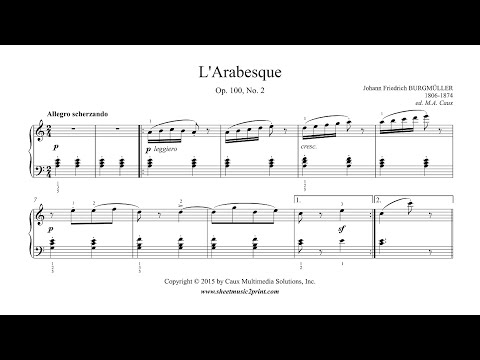

In [ ]:
ipd.YouTubeVideo('1oMm_n38OxQ')

Observe como cada versão diferente tem uma duração distinta. Mesmo que expressássemos os dois sinais de áudio usando o mesmo espaço de recursos (por exemplo, espectrogramas), não poderíamos simplesmente usar uma distâncias entre pares simples. Os sinais têm comprimentos diferentes (4 segundos de diferença).

Como visto em sala de aula, o problema de alinhamento de músicas tem diversas aplicações nas bibliotecas digitais musicais. Uma delas, são aplicativos que permitem o chaveamento entre diferentes versões em um mesmo instante de tempo (na mesma nota). Uma outra é a análise de performance.

Para alinhar músicas vamos fazer uso de *Dynamic Time Warping*.

## Dynamic Time Warping

### Do Wikipedia

Dynamic time warping (DTW) é um algoritmo para comparar e alinhar duas séries temporais. A DTW é utilizada para encontrar o alinhamento não-linear ótimo entre duas sequências de valores numéricos. Dessa maneira, é possível encontrar padrões entre medições de eventos com diferentes ritmos. Por exemplo, é possível casar a série temporal obtida por acelerômetros (ou outros sensores) de duas pessoas andando em diferentes velocidades.

DTW pode ser utilizada para alinhar qualquer tipo de dado que obedeça uma ordem temporal, como vídeo, áudio e imagens. Entre as diversas aplicações da DTW, encontra-se o reconhecimento de fala e de assinatura, bem como o alinhamento de gravações musicais com suas respectivas partituras.

**Exemplo**

Para entender o algoritmo, vamos criar duas vetores de tamanhos distintos.

In [ ]:
x = np.array([1, 4, 4, 2, -4, -4, 9])
y = np.array([1, 3, 4, 3, 1, -1, -2, -1, 12])
nx = len(x)
ny = len(y)

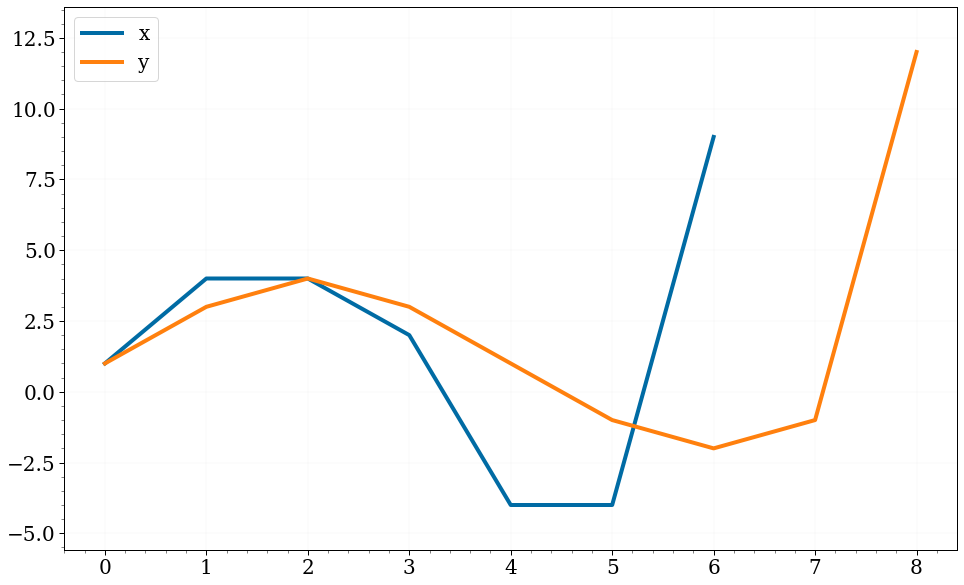

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x)
ax.plot(y)
ax.legend(('x', 'y'))

Neste exemplo simples, há apenas um valor ou "atributo" em cada índice de tempo. Na prática, você pode usar sequências de vetores, por exemplo, espectrogramas ou cromogramas.

### Distância

O DTW requer o uso de uma métrica de distância entre as observações correspondentes de $x$ e $y$. 

**Euclidiana**

Uma escolha comum é a distância euclidiana.

$$d(\mathbf{f}_1, \mathbf{f}_2) = || \mathbf{f}_1 - \mathbf{f}_2 || = \sqrt{\sum_i (\mathbf{f}_1[i] - \mathbf{f}_2[i])^2}$$

Observe como os vetores aqui tem as mesmas dimensões. Tal dimensão **não é o tempo**, sim o **número de observações por tempo**. No exemplo acima temos apenas uma observação por tempo. Porém, ao fazer o cromagrama de uma música, vide abaixo, teremos 12 observações por tempo.

No exemplo abaixo temos duas observações por tempo.

**Coseno**

Uma outra métrica de distância é o 1-coseno. Quando dois vetores apontam na mesma direção, o coseno entre os mesmos é 1. Quando apontam em direções opostas, o coseno vira 0. Assim, vamo fazer 1-coseno vamos capturar uma noção de distância que não se importa com a magnitude dos valores, sim com a direção dos vetores.

![](https://github.com/flaviovdf/musica/blob/main/notebooks/cos.png?raw=1)

In [ ]:
import scipy.spatial as sp
sp.distance.cosine([1, 0], [5, 12])

0.6153846153846154

Observe que magnitudes diferentes apontando na mesma direção

In [ ]:
sp.distance.cosine([1, 1], [9, 9])

0.0

### Cromagrama

Como vimos em sala de aula, podemos usar o **cromagrama**, ou **vetor de cromas**, para representar músicas. Um vetor de croma é um vetor de característica de 12 elementos. Cada elemento indica a quantidade de energia em um *semitom* {C, C #, D, D #, E, ..., B}.

Vamos comparar dois vetores de croma da mesma música usando librosa.

Carregando uma música com librosa. Vamos focar nos primeiros 15 segundos da música apenas. Nossa comparação será de duas versões da música [Body and Soul](https://en.wikipedia.org/wiki/Body_and_Soul_(1930_song)). 

**Do Wikipedia**

"Body and Soul" foi escrita para a atriz e cantora inglesa Gertrude Lawrence, sendo interpretada pela primeira vez por ela, ainda na Inglaterra. Libby Holman foi a responsável pelo lançamento da canção nos Estados Unidos. Inicialmente, a música foi proibida de ser executada nas estações de rádio do país, porém a popularidade da canção cresceu muito nas décadas de 1930 e 1940, sendo regravada por uma série de artistas. A primeira regravação de "Body and Soul" foi feita ainda em 1930 pelo cantor estadunidense Louis Armstrong, que após o seu lançamento alcançou o número 12 na parada de singles norte-americana. Até o final da década, a canção havia sido regravada por 11 grupos, senda a mais bem-sucedida nas paradas a versão original da canção lançada por Libby Holman tando atingido o número 3. "Body and Soul" continua a ser um padrão de jazz, com centenas de versões cantadas e gravadas por dezenas de artistas. Clássicas gravações vocais incluem as de: Ella Fitzgerald, Hanshaw Annette, Billie Holiday, Billy Eckstine , Etta James , Sarah Vaughan e Frank Sinatra, e músicos como Benny Goodman, Lee Konitz, John Coltrane, Charles Mingus, Dexter Gordon, Sonny Stitt e Lester Young.

**MP3s**

Na pasta `mp3s` existem diferentes versões de Body and Soul. As mesmas foram identificadas com ajuda da base de dados chamada de [JazzTube](http://mir.audiolabs.uni-erlangen.de/jazztube). O JazzTube contém um série de referências a clássicos do Jazz no YouTube. Caso queira, explore a base pois pode ser uma fonte para projetos futuros.

O professor da disciplina baixou os mp3s do YouTube usando a ferramenta [youtube-dl](https://youtube-dl.org/). Abaixo segue um exemplo de uso da mesma, não precisa executar.

```bash
$ youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=_OFMkCeP6ok
```

*Abaixo uma versão antiga de Chu Berry e Roy Eldridge*

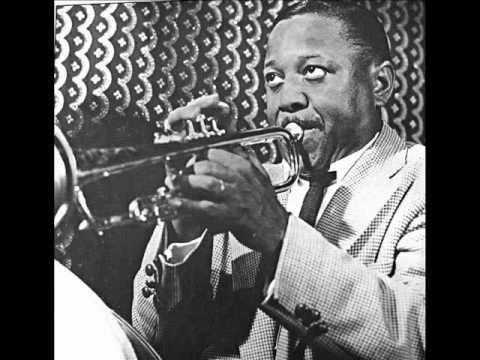

In [ ]:
ipd.YouTubeVideo('Lor80WUVbtw')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


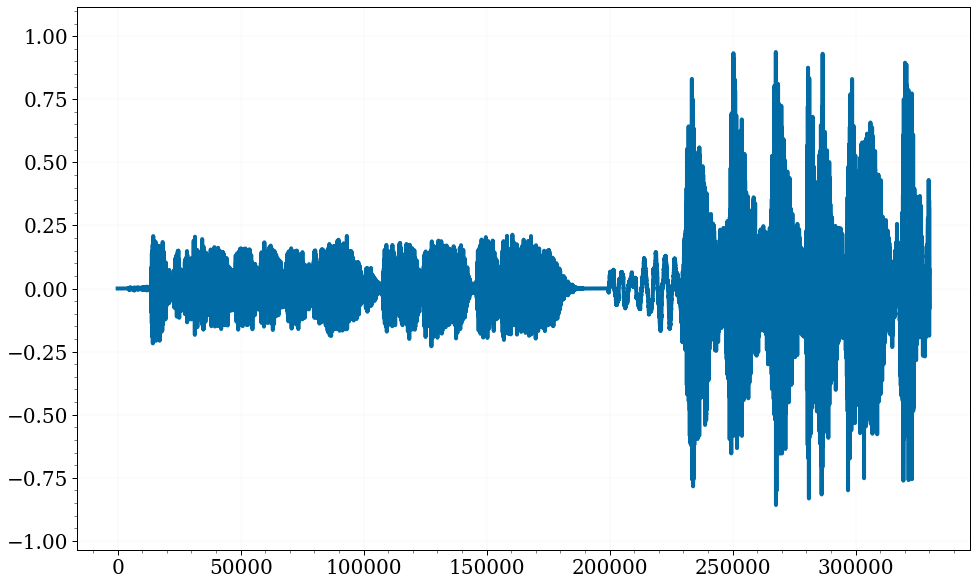

In [ ]:
wave_classic, sr = librosa.load('mp3s/Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3',
                                duration=15, sr=22000)
plt.plot(wave_classic)

Vamos computar o cromograma da música com librosa.

In [ ]:
chroma_classic = librosa.feature.chroma_stft(wave_classic, sr=sr)
chroma_classic.shape

(12, 645)

Plotar o mesmo.

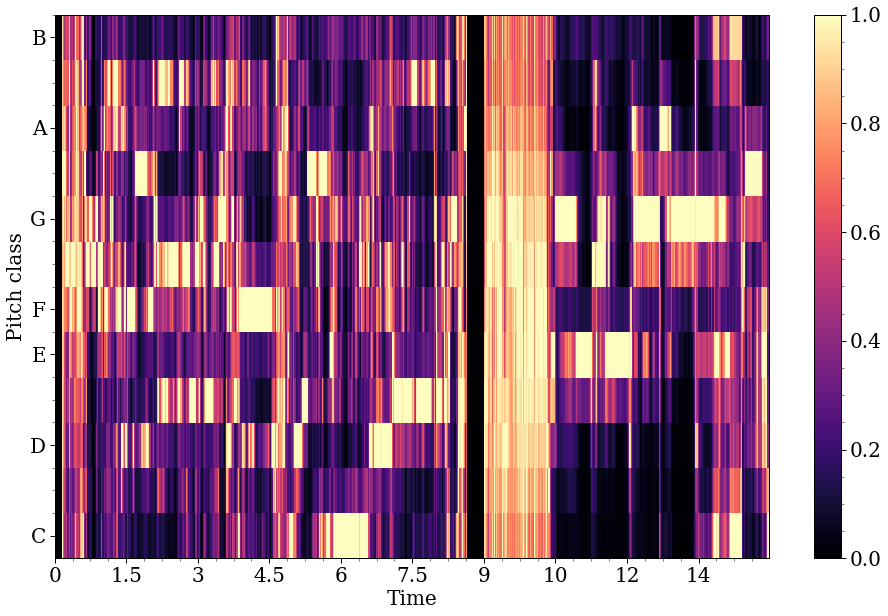

In [ ]:
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

*Agora uma versão mais nova de Tony Bennett e Amy Winehouse*

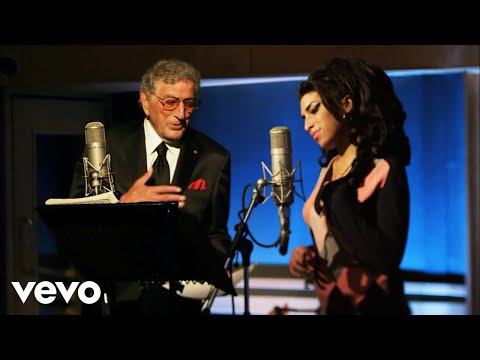

In [ ]:
ipd.YouTubeVideo('_OFMkCeP6ok')

Tanto em áudio quanto em cromagrama, as duas versões são bem diferentes.

In [ ]:
wave_amy, sr = librosa.load('mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3',
                        duration=15)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


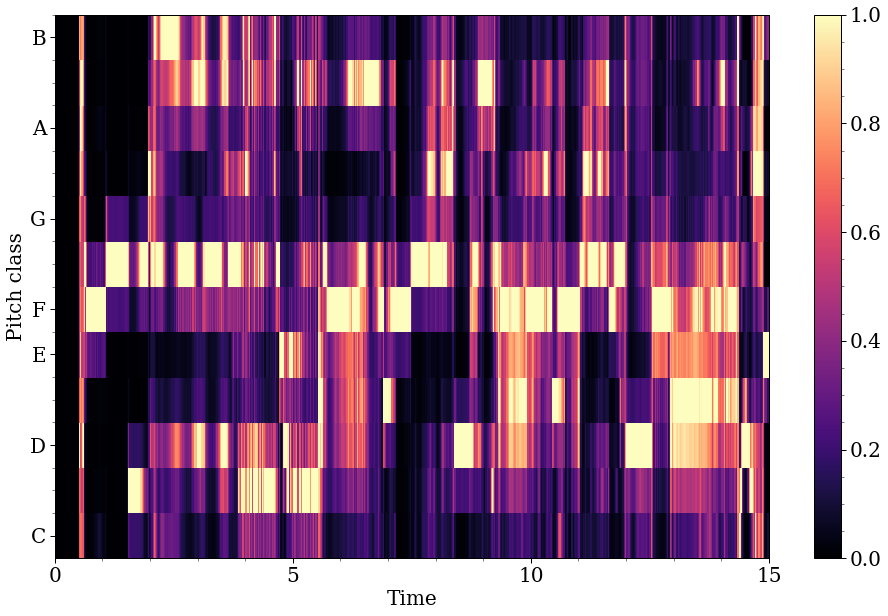

In [ ]:
chroma_amy = librosa.feature.chroma_stft(wave_amy, sr=sr)
chroma_amy.shape
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Para comparar as duas com DTW, temos que computar a distância coseno entre as colunas.

In [ ]:
print(chroma_classic[:, 0].shape)
print(chroma_amy[:, 0].shape)

(12,)
(12,)


Aqui observamos nosso primeiro problema, a presença de zeros leva a disância para `nan`. Portanto, é mais comum usar versões suavizadas do cromagrama.

In [ ]:
sp.distance.cosine(chroma_classic[:, 100], chroma_amy[:, 60])

0.3710134029388428

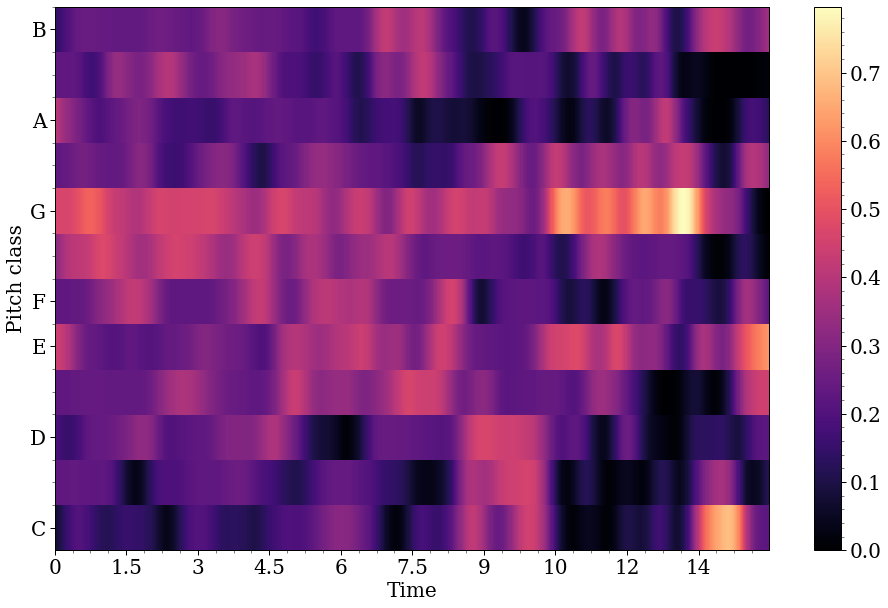

In [ ]:
chroma_classic = librosa.feature.chroma_cens(wave_classic, sr=sr)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

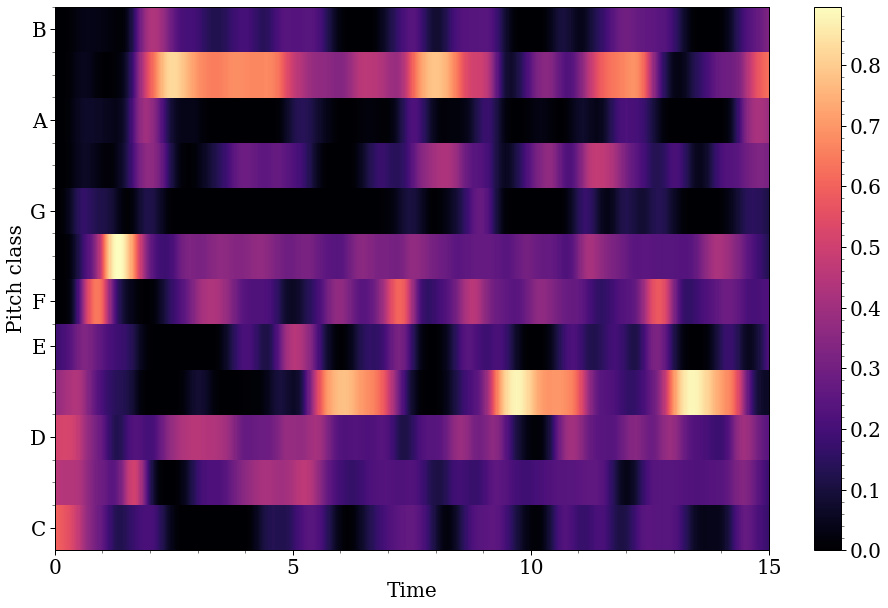

In [ ]:
chroma_amy = librosa.feature.chroma_cens(wave_amy, sr=sr)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Qual foi a ideia? Veja os slides das aula.

1. Tirar o log para ficar em uma *escala mais musical*
1. Somar uma pequena constante
1. Normalizar as colunas
1. Dentre outros

In [ ]:
sp.distance.cosine(chroma_classic[:, 0], chroma_amy[:, 0])

0.5900771244523135

## Tarefa 1

Agora vamos programar. Sua primeira tarefa é implementar o Dynamic Time Warping. Seu código deve fazer uso de duas funções, uma para computar a matriz de custo. Esta se chama `dtw_table` abaixo. Pode usar a distância euclideana por simplicidade. 

![](https://dcc.ufmg.br/~flaviovdf/mir/lab05/imgs/saida1.png)

**Questão 1**

Seu código deve gerar uma saída como a acima. Caso fique igual, 100%. Observe que a mesma não corresponde as saída do livros, Python indexa de cima para baixo. O livro de baixo para cima. De qualquer forma, isto é apenas um pequeno detalhe que não muda o algoritmo. Caso queira, mude o código para receber uma função de distância.

Seu código abaixo já vai receber matrizes onde as colunas são tempo e as linhas são observações.

In [ ]:
def dtw_table(X, Y):
    '''
    Retorna a matriz de DTW entre as músicas.
    
    Argumentos
    ----------
    X: matriz onde as colunas são tempo e as linhas são atributos
    Y: matriz onde as colunas são tempo e as linhas são atributos
    ''' 
    n_x = X.shape[1]
    n_y = Y.shape[1]
    
    D = np.zeros(shape=(n_x, n_y), dtype='d')
    return D

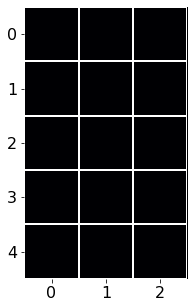

In [ ]:
def plot_dtw_table(D, path=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(D, cmap='magma')
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.set_xticks(np.arange(D.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(D.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    if path:
        x = []
        y = []
        for n, m in path:
            y.append(n)
            x.append(m)
        ax.plot(x, y, color='r')
    
D = dtw_table(x[None], y[None]) # Não apagar isto é o teste!!!
plot_dtw_table(D)

**Questão 2**

Agora, crie uma função que retorna uma lista de tuplas. Esta lista contém o caminho ótimo do DTW. Para o exemplo acima com distância euclidiana, o caminho é:

```
[(6, 8),
 (5, 7),
 (5, 6),
 (4, 5),
 (3, 4),
 (3, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (0, 0)]
 ```
 
O plot agora deve ficar estilo a figura abaixo.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab05/imgs/saida2.png)

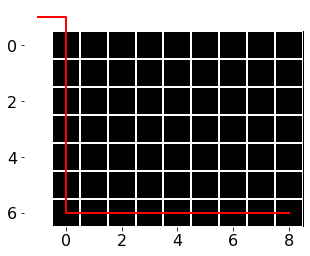

In [ ]:
def dtw(X, Y):
    if X.ndim == 1:
        X = X[None]
        Y = Y[None]
        
    D = dtw_table(X, Y)
    
    n_x = X.shape[1]
    n_y = Y.shape[1]
    
    n = n_x - 1
    m = n_y - 1
    path = [(n, m)]
    
    while n > 0 or m > 0:
        if n == 0:
            while m > 0:
                m = m - 1
                path += [(n, m)]

        if m == 0:
            while n > 0:
                n = m - 1
                path += [(n, m)]
                
        if D[n - 1, m - 1] < D[n - 1, m] and D[n - 1, m - 1] < D[n, m - 1]:
            n = n - 1
            m = m - 1
        elif D[n - 1, m] < D[n, m - 1]:
            n = n - 1
        else:
            m = m - 1
        path += [(n, m)]
    return D, path

D, path = dtw(x, y)
plot_dtw_table(D, path)

## Tarefa 2

Usando a biblioteca [FastDTW](https://github.com/slaypni/fastdtw) ordena as versões das músicas que são mais e menos similares com a versão de Tony Bennet e Amy Winehouse

```bash
$ pip install fastdtw
```

A biblioteca FastDTW é interessante pois é toda linear em tempo e memória. Assim, podemos computar a distância entre versões inteiras de músicas. Faça isso. Caso não execute, trunque em 2mins. Caso não execute, trunque em 1 min.

Abaixo executo a FastDTW com os 15 segundos que carregamos antes. Observe como passo a transposta, pois a biblioteca funciona em linhas, não em colunas, como o livro.

In [ ]:
from fastdtw import fastdtw
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(chroma_amy.T, chroma_classic.T, dist=ss.distance.cosine)

In [ ]:
distance

202.5964747596338

In [ ]:
path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 39),
 (41, 39),
 (42, 39),
 (43, 39),
 (44, 39),
 (45, 39),
 (46, 39),
 (47, 39),
 (48, 39),
 (49, 39),
 (50, 39),
 (51, 39),
 (52, 39),
 (53, 39),
 (54, 39),
 (55, 39),
 (56, 39),
 (57, 39),
 (58, 39),
 (59, 39),
 (60, 39),
 (61, 39),
 (62, 39),
 (63, 40),
 (64, 41),
 (65, 42),
 (66, 43),
 (67, 44),
 (68, 45),
 (69, 46),
 (70, 47),
 (71, 48),
 (72, 49),
 (73, 50),
 (74, 51),
 (75, 52),
 (76, 53),
 (77, 54),
 (78, 55),
 (79, 56),
 (80, 57),
 (81, 58),
 (82, 59),
 (83, 60),
 (84, 61),
 (85, 62),
 (86, 63),
 (87, 64),
 (88, 65),
 (89, 66),
 (90, 67),
 (91, 68),
 (92, 69

**Questão 1**

Ordene as músicas por similaridade com a versão mais recent (Bennet e Winehouse). Indique sua resposta abaixo.

> Sua respota. Ou seja, os ids do YouTube aqui do mais até o menos similar. Escute as músicas, você percebe a similaridade? Em quais aspectos?

**Questão 2**

Plote o caminho de sincronização da música mais e menos similar. Isto é, no eixo-x você pode usar o tempo da música referência (Bennet e Winehouse). No eixo-y, o tempo das outras músicas. 

> Qual interpretação você tira do plot?

**Questão 3**

Plote os cromagramas da músicas mais e menos similar. Compare com a versão base.

> Qual interpretação você tira do plot?